In [1]:
from HeaderP import *

In [2]:
import Astraea

In [3]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data
        

# predict rbirth with Minchev 2018

## Get present day metallicity gradient and gradient with time in the Solar neighborhood

In [4]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=2


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)

In [5]:
len(data)

7315685

In [6]:
import random

SolarRad=8.2*(5./3.)

def getbin(x,y,binnumb=100):
    xbin=np.linspace(min(x),max(x),binnumb)
    x_bin=((max(x)-min(x))/binnumb)/2+xbin[:-1]
    y_bin=np.zeros(len(x_bin))
    for i in range(len(x_bin)):
        m=(x>xbin[i])&(x<xbin[i+1])
        y_bin[i]=np.median(y[m])
    return x_bin, y_bin
    

def get_SR(feh, x, y,xbir,ybir, radius=0.2*(5./3.), plotpoints=False):
    # radius: how big the solar circle is...
    
    # generate random location of the sun
    x_sun=random.uniform(-SolarRad, SolarRad)
    y_sun=np.sqrt(SolarRad**2.-x_sun**2.)*np.random.choice([-1,1])
    
    # get stars in the solar circle
    m=(((x-x_sun)**2.+(y-y_sun)**2.)<radius**2.)
    
    feh_sr, x_sr, y_sr = feh[m], xbir[m], ybir[m]
    
    r_sr=np.sqrt(x[m]**2. + y[m]**2.)
    
    if plotpoints:
        plt.figure()
        plt.plot(xbir,ybir,'k.',markersize=0.01,alpha=0.5)
        plt.plot(x_sr, y_sr,'r.',markersize=5)
        plt.xlabel('xbir')
        plt.ylabel('ybir')
        plt.legend()
        
    return feh_sr, r_sr, m


def calc_dfedr_SR(feh, r, plotpoints=False):
    r_bin, feh_bin = getbin(r, feh, binnumb=100)
    p = fitpoints(r_bin,feh_bin)
    if plotpoints:
        plt.figure()
        plt.plot(r_bin,feh_bin,'k.',markersize=5)
        plt.plot([min(r_bin),max(r_bin)],p([min(r_bin),max(r_bin)]),'r-',label='Gradient = %.4f'%(p[1]))
        plt.xlabel('R')
        plt.ylabel('[Fe/H]')
        plt.legend()
    return p[1]

No handles with labels found to put in legend.


-0.06371847407820108


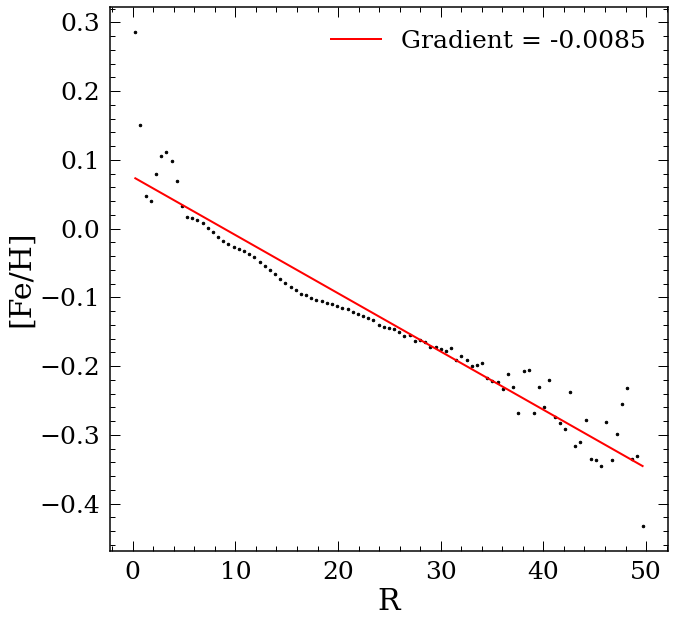

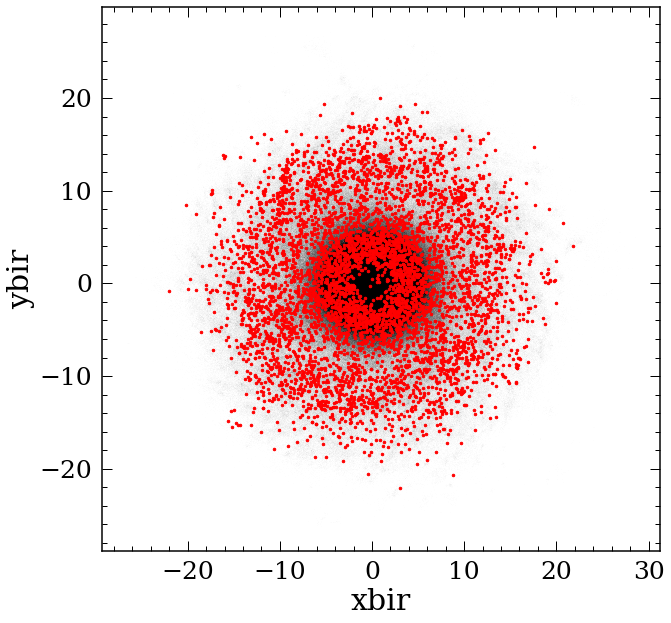

In [7]:
radtotest=1
# present day metallicity gradient
p=calc_dfedr_SR(data['feh_scale'].values,data['R'].values,plotpoints=True)

# present day metallicity in the solar neighborhood
feh_sr, r_sr, m_sr = get_SR(data['feh_scale'].values, data['x'].values, data['y'].values,
                            data['x_birth'].values,data['y_birth'].values,radius=radtotest,plotpoints=True)


srm=(abs(data['R']-SolarRad)<radtotest)
feh_p = np.median(data['feh_scale'][srm])
print(feh_p)


Text(0.5, 0, '[Fe/H]')

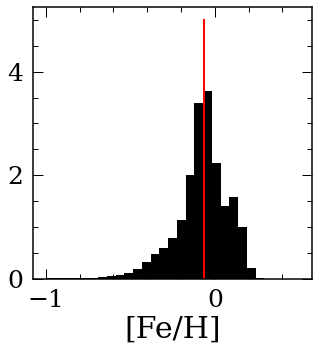

In [8]:
plt.figure(figsize=(5,5))
plt.hist(data['feh_scale'][srm],bins=np.linspace(-1,0.5,30),color='k',density=True)
plt.plot([feh_p,feh_p],[0,5],'r-')
plt.xlabel('[Fe/H]')

## optimize with MCMC

In [9]:
currentt=0.05
slopet=0.05
slopenorm=3

def getfeh_sr(t):
    return currentt*np.log(14-t)-currentt*np.log(14)+feh_p

def getfeh_slope(t):
    return slopet*(math.log(15-t,slopenorm))+p-slopet*(math.log(15,slopenorm))

def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]


In [10]:
ages_sr = data['age'][m_sr].values
r_birth_true = data['R_bir'][m_sr].values
print(len(r_birth_true),len(ages_sr))

5626 5626


(14.0, 0.0)

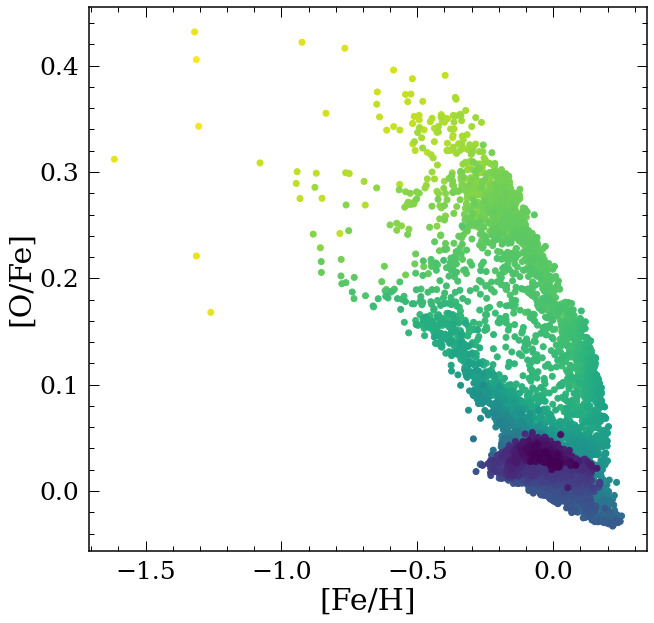

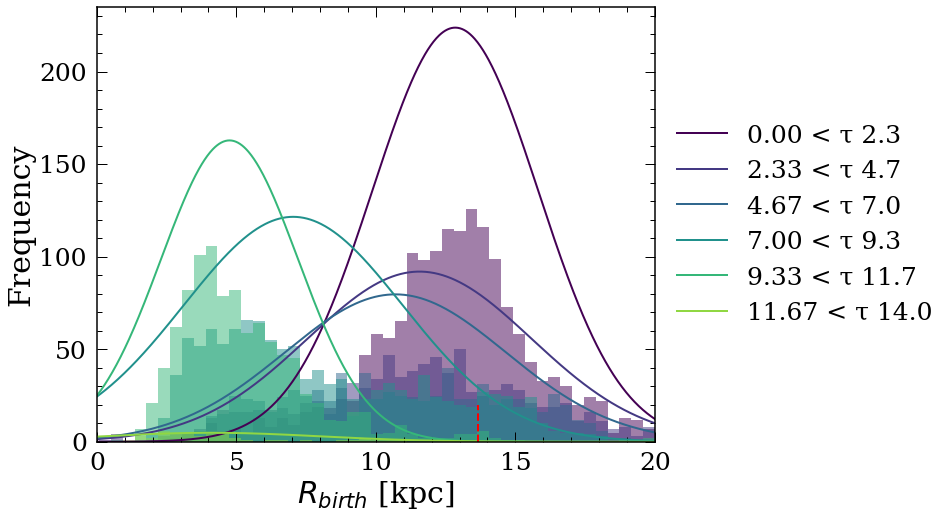

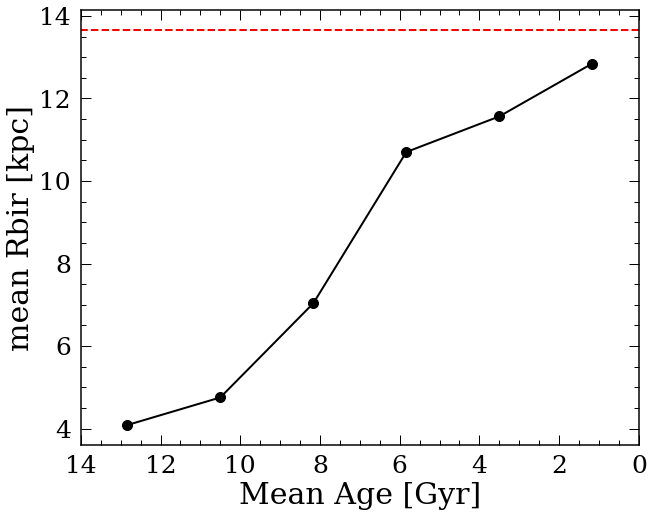

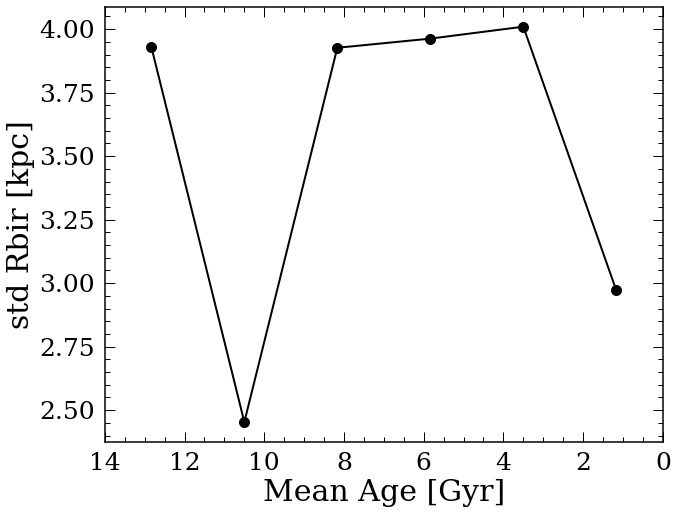

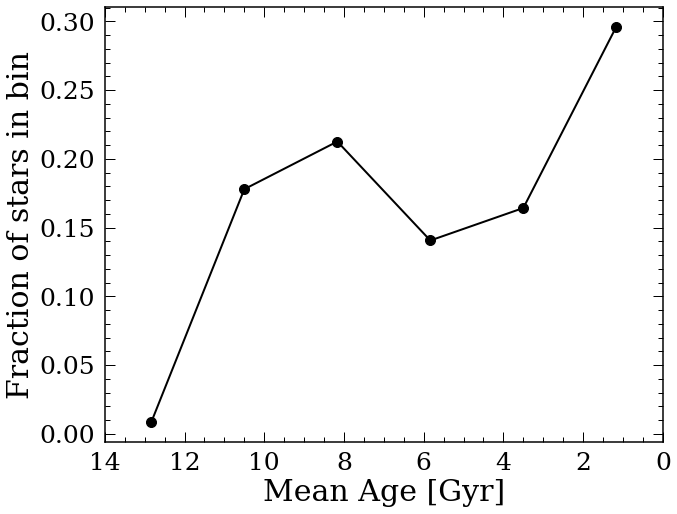

In [11]:
numbofbins=6
plt.scatter(feh_sr,data['ofe_scale'][m_sr],c=data['age'][m_sr])
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')

import seaborn as sns
import matplotlib
# historgram of mono-age population
plt.figure(figsize=(10,8))
agebin=np.linspace(0,14,numbofbins+1)
colors_feh = getcolor(agebin)

meanrbirth = np.zeros(numbofbins)
stdbirth = np.zeros(numbofbins)
numbstars = np.zeros(numbofbins)
for i in range(len(agebin)-1):
    
    m=(ages_sr>=agebin[i])&(ages_sr<=agebin[i+1])
    plt.hist(r_birth_true[m], color=colors_feh[i], bins=np.linspace(-5,20,60), alpha=0.5)
    meanrbirth[i]=np.median(r_birth_true[m])
    stdbirth[i]=np.std(r_birth_true[m])
    gausd=sum(m)/(np.std(r_birth_true[m]) * np.sqrt(2 * np.pi)) * np.exp( - (np.linspace(-5,20,1000) - np.median(r_birth_true[m]))**2 / (2 * np.std(r_birth_true[m])**2))
    numbstars[i]=sum(m)
    plt.plot(np.linspace(-5,20,1000), gausd, color=colors_feh[i], label='%.2f < τ %.1f'%(agebin[i], agebin[i+1]))
    
plt.plot([SolarRad,SolarRad],[0,20],'r--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$R_{birth}$ [kpc]')
plt.ylabel('Frequency')
plt.xlim([0,20])


plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),meanrbirth,'ko-',markersize=10)
plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('mean Rbir [kpc]')
plt.xlim([14,0])

plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),stdbirth,'ko-',markersize=10)
#plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('std Rbir [kpc]')
plt.xlim([14,0])

plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),numbstars/sum(numbstars),'ko-',markersize=10)
#plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('Fraction of stars in bin')
plt.xlim([14,0])

In [12]:
SolarRad=8.2*(5./3.)
def feh_lookback(t):
    m=getfeh_slope(t)
    y=getfeh_sr(t)
    b=y-m*SolarRad
    return m, b

def get_chisq(para, feh, age, meanRbir, meanStd):
    m, b = para
    # put stars back into their birth raii
    rbirth_inf = (feh-b)/m
    
    #return (np.median(rbirth_inf)-meanRbir)**2/meanRbir+(np.std(rbirth_inf)-meanStd)**2/meanStd
    return (np.median(rbirth_inf)-meanRbir)**2


# fitting to mean and standard deviation

In [13]:
fehISM=pd.DataFrame(pd.read_pickle('../SimulationData/Data/g2.79e12_ISM_metallicity.dat')['feh']).T
ageISM=14-pd.DataFrame(pd.read_pickle('../SimulationData/Data/g2.79e12_ISM_metallicity.dat')['time']).T

scale_fe=0.250019907951355/0.35828184923028494
fehISM=fehISM*scale_fe-0.0906638577580452+0.08980628554112494

fehISM[0]=np.array(fehISM[0],dtype=float)
fehISM[1]=np.array(fehISM[1],dtype=float)
fehISM[2]=np.array(fehISM[2],dtype=float)
fehISM[3]=np.array(fehISM[3],dtype=float)
fehISM[4]=np.array(fehISM[4],dtype=float)
fehISM[5]=np.array(fehISM[5],dtype=float)
fehISM[6]=np.array(fehISM[6],dtype=float)
fehISM[7]=np.array(fehISM[7],dtype=float)

ageISM[0]=np.array(ageISM[0],dtype=float)
ageISM[1]=np.array(ageISM[1],dtype=float)
ageISM[2]=np.array(ageISM[2],dtype=float)
ageISM[3]=np.array(ageISM[3],dtype=float)
ageISM[4]=np.array(ageISM[4],dtype=float)
ageISM[5]=np.array(ageISM[5],dtype=float)
ageISM[6]=np.array(ageISM[6],dtype=float)
ageISM[7]=np.array(ageISM[7],dtype=float)

ISMdic={0:'0-2 kpc',1:'2-4 kpc',2:'4-6 kpc',3:'6-8 kpc',
       4:'8-10 kpc',5:'10-12 kpc',6:'12-14 kpc',7:'14-20 kpc'}

In [63]:

# get true slope
slopes_ism = np.zeros(len(agebin)-1)
for i in range(len(agebin)-1):
    feh_ism=np.zeros(8)
    for j in range(8):
        m = ((ageISM[j]>agebin[i])&(ageISM[j]<agebin[i+1]))
        feh_ism[j] = np.mean(fehISM[j][m].dropna())
    slopes_ism[i]=fitpoints(np.array([1,3,5,7,9,11,13,17]),feh_ism)[1]
    
from scipy import interpolate
f_slope = interpolate.interp1d((agebin[:-1]+np.diff(agebin)[0]/2),slopes_ism, kind='cubic')
f_feh = interpolate.interp1d(ageISM[6],fehISM[6])

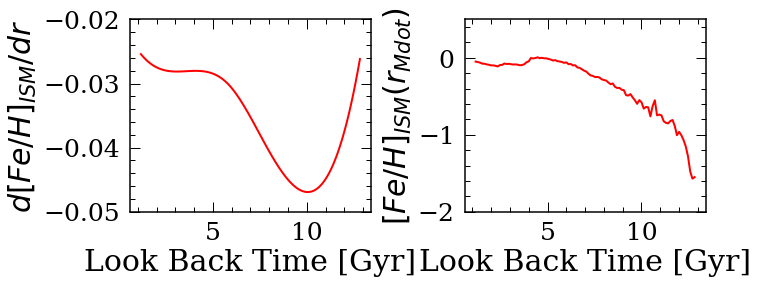

In [74]:
from scipy.interpolate import interp1d
# plot the results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(minagebin,maxagebin,100),f_slope(np.linspace(minagebin,maxagebin,100)),'r-')
plt.ylim([-0.05,-0.02])
plt.xlabel('Look Back Time [Gyr]')
plt.ylabel('$d[Fe/H]_{ISM}/dr$')

plt.subplot(1,2,2)
plt.plot(np.linspace(minagebin,maxagebin,100),f_feh(np.linspace(minagebin,maxagebin,100)),'r-')
plt.xlabel('Look Back Time [Gyr]')
plt.ylabel('$[Fe/H]_{ISM}(r_{Mdot})$')
plt.ylim([-2,0.5])
plt.tight_layout()

In [75]:
# get birth radii this way and plot against real birth radii
minagebin = min((agebin[:-1]+np.diff(agebin)[0]/2))
maxagebin = max((agebin[:-1]+np.diff(agebin)[0]/2))

rbirth_inf = np.zeros(len(ages_sr))
for i in range(len(ages_sr)):
    # get relation
    if ages_sr[i]<minagebin:
        m = f_slope(minagebin)
        b = f_feh(minagebin)-m*SolarRad
    elif ages_sr[i]>maxagebin:
        m = f_slope(maxagebin)
        b = f_feh(maxagebin)-m*SolarRad
    else:
        m = f_slope(ages_sr[i])
        b = f_feh(ages_sr[i])-m*SolarRad
    rbirth_inf[i] = (feh_sr[i]-b)/m



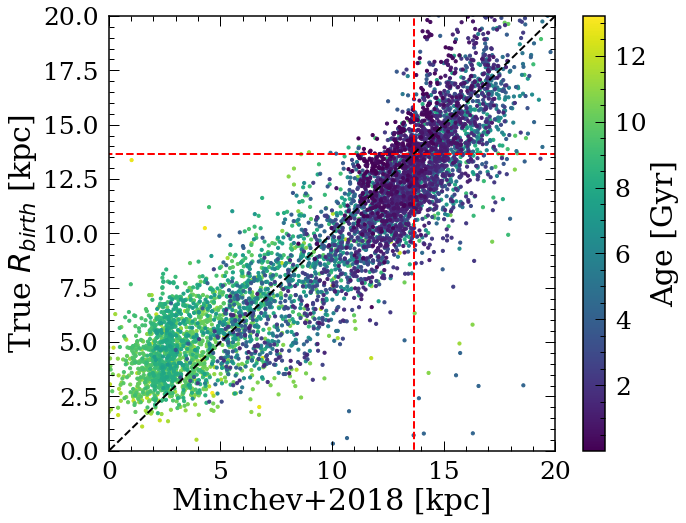

In [76]:
plt.figure(figsize=(10,8))
plt.scatter(rbirth_inf, r_birth_true, s=10, c = ages_sr)
plt.plot([SolarRad,SolarRad],[-10,20],'r--')
plt.plot([-10,20],[SolarRad,SolarRad],'r--')
plt.plot([-10,20],[-10,20],'k--')
plt.xlim([0,20])
plt.ylim([0,20])
plt.xlabel('Minchev+2018 [kpc]')
plt.ylabel('True $R_{birth}$ [kpc]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)

(14.0, 0.0)

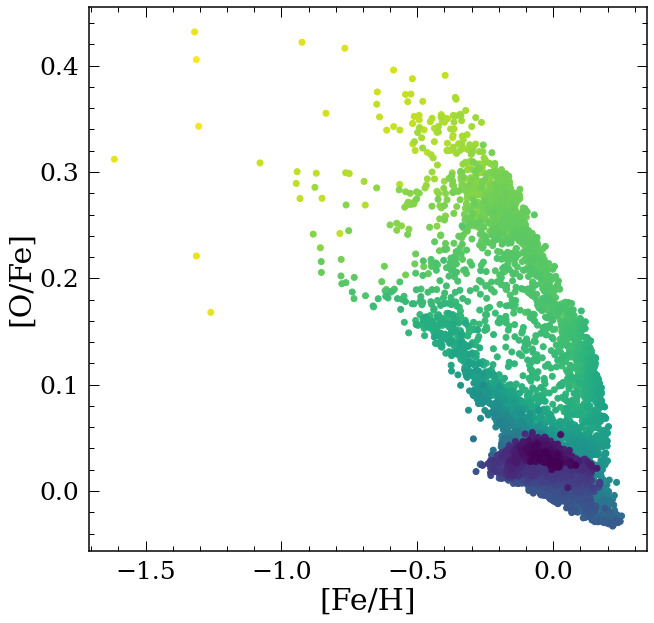

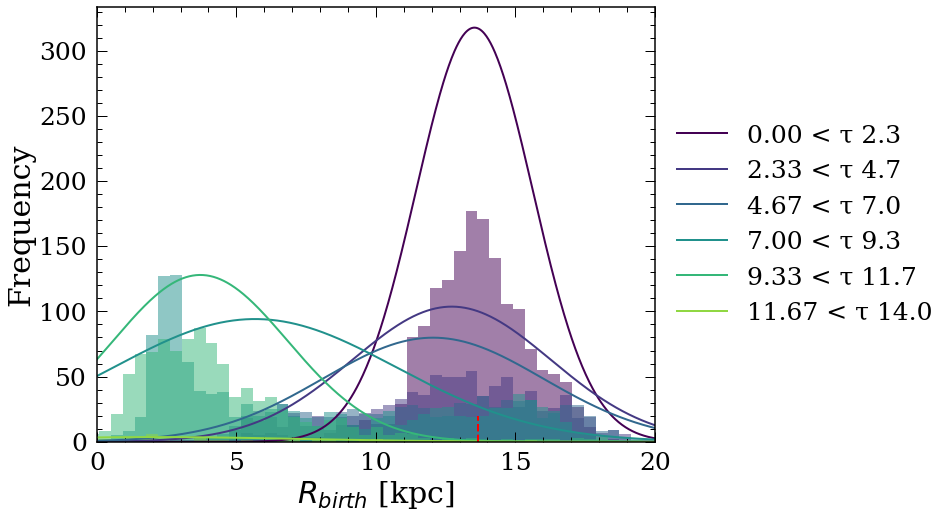

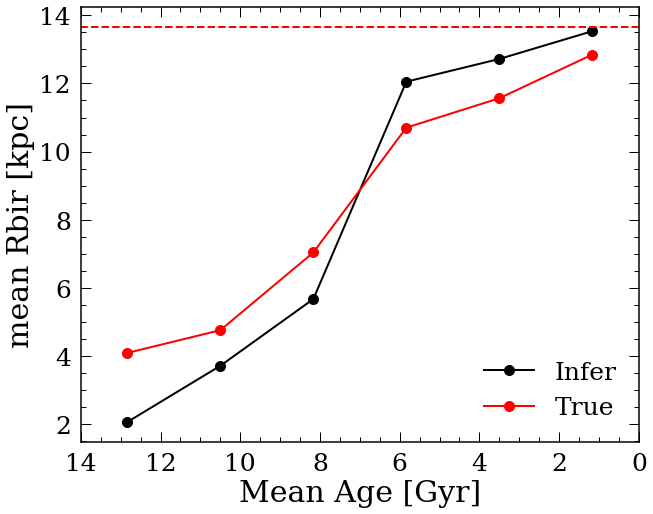

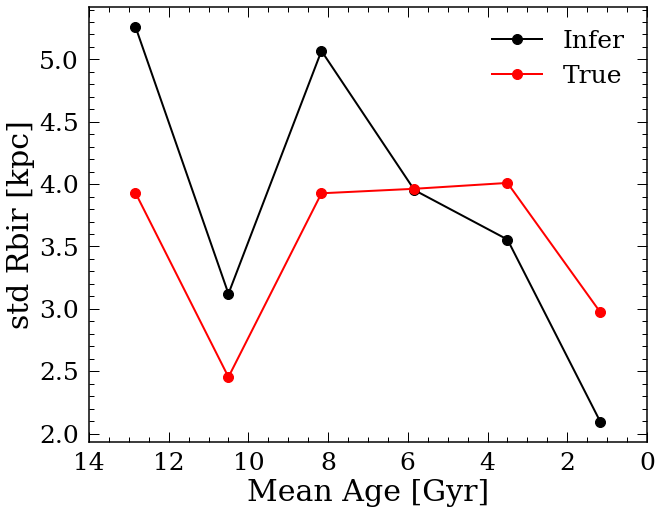

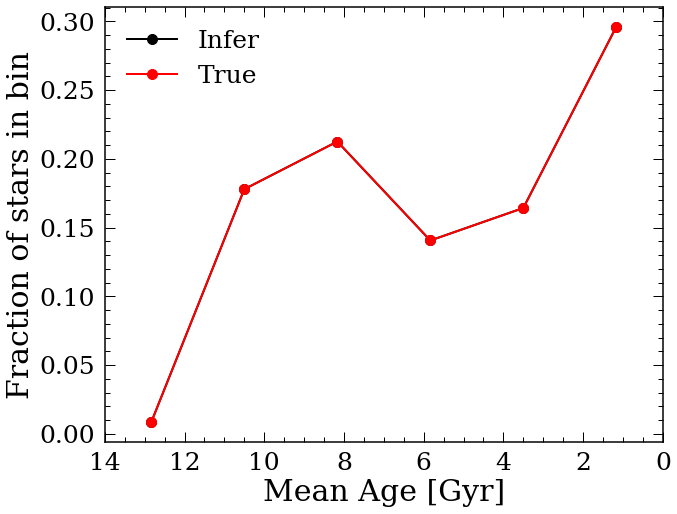

In [77]:
numbofbins=6
plt.scatter(feh_sr,data['ofe_scale'][m_sr],c=data['age'][m_sr])
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')

import seaborn as sns
import matplotlib
# historgram of mono-age population
plt.figure(figsize=(10,8))

meanrbirth_inf = np.zeros(numbofbins)
stdbirth_inf = np.zeros(numbofbins)
numbstars_inf = np.zeros(numbofbins)
for i in range(len(agebin)-1):
    
    m=(ages_sr>=agebin[i])&(ages_sr<=agebin[i+1])
    plt.hist(rbirth_inf[m], color=colors_feh[i], bins=np.linspace(-5,20,60), alpha=0.5)
    meanrbirth_inf[i]=np.median(rbirth_inf[m])
    stdbirth_inf[i]=np.std(rbirth_inf[m])
    gausd=sum(m)/(np.std(rbirth_inf[m]) * np.sqrt(2 * np.pi)) * np.exp( - (np.linspace(-5,20,1000) - np.median(rbirth_inf[m]))**2 / (2 * np.std(rbirth_inf[m])**2))
    numbstars_inf[i]=sum(m)
    plt.plot(np.linspace(-5,20,1000), gausd, color=colors_feh[i], label='%.2f < τ %.1f'%(agebin[i], agebin[i+1]))
    
plt.plot([SolarRad,SolarRad],[0,20],'r--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$R_{birth}$ [kpc]')
plt.ylabel('Frequency')
plt.xlim([0,20])


plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),meanrbirth_inf,'ko-',markersize=10,label='Infer')
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),meanrbirth,'ro-',markersize=10,label='True')
plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('mean Rbir [kpc]')
plt.legend()
plt.xlim([14,0])

plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),stdbirth_inf,'ko-',markersize=10,label='Infer')
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),stdbirth,'ro-',markersize=10,label='True')
#plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('std Rbir [kpc]')
plt.legend()
plt.xlim([14,0])

plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),numbstars_inf/sum(numbstars_inf),'ko-',markersize=10,label='Infer')
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),numbstars/sum(numbstars),'ro-',markersize=10,label='True')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('Fraction of stars in bin')
plt.legend()
plt.xlim([14,0])

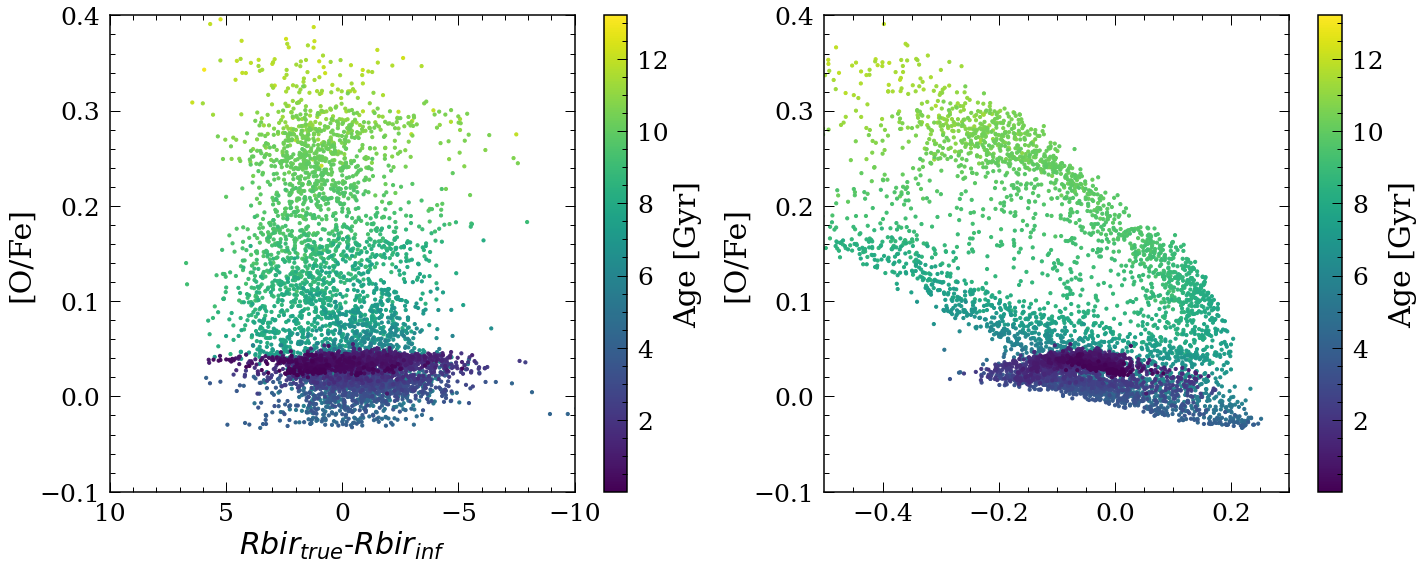

In [78]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(r_birth_true-rbirth_inf, data['ofe_scale'][m_sr].values, s=10, 
            c = data['age'][m_sr].values)
plt.xlim([10,-10])
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.ylim([-0.1,0.4])
plt.ylabel('[O/Fe]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)

plt.subplot(1,2,2)
plt.scatter(data['feh_scale'][m_sr].values, data['ofe_scale'][m_sr].values, s=10, c = ages_sr)
plt.ylim([-0.1,0.4])
plt.xlim([-0.5,0.3])
plt.ylabel('[O/Fe]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)
plt.tight_layout()

<ipython-input-79-ed3b9b9f7fa4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sr['hi_low']=data_sr['ofe_scale']-p_hilow(data_sr['feh_scale'])>0


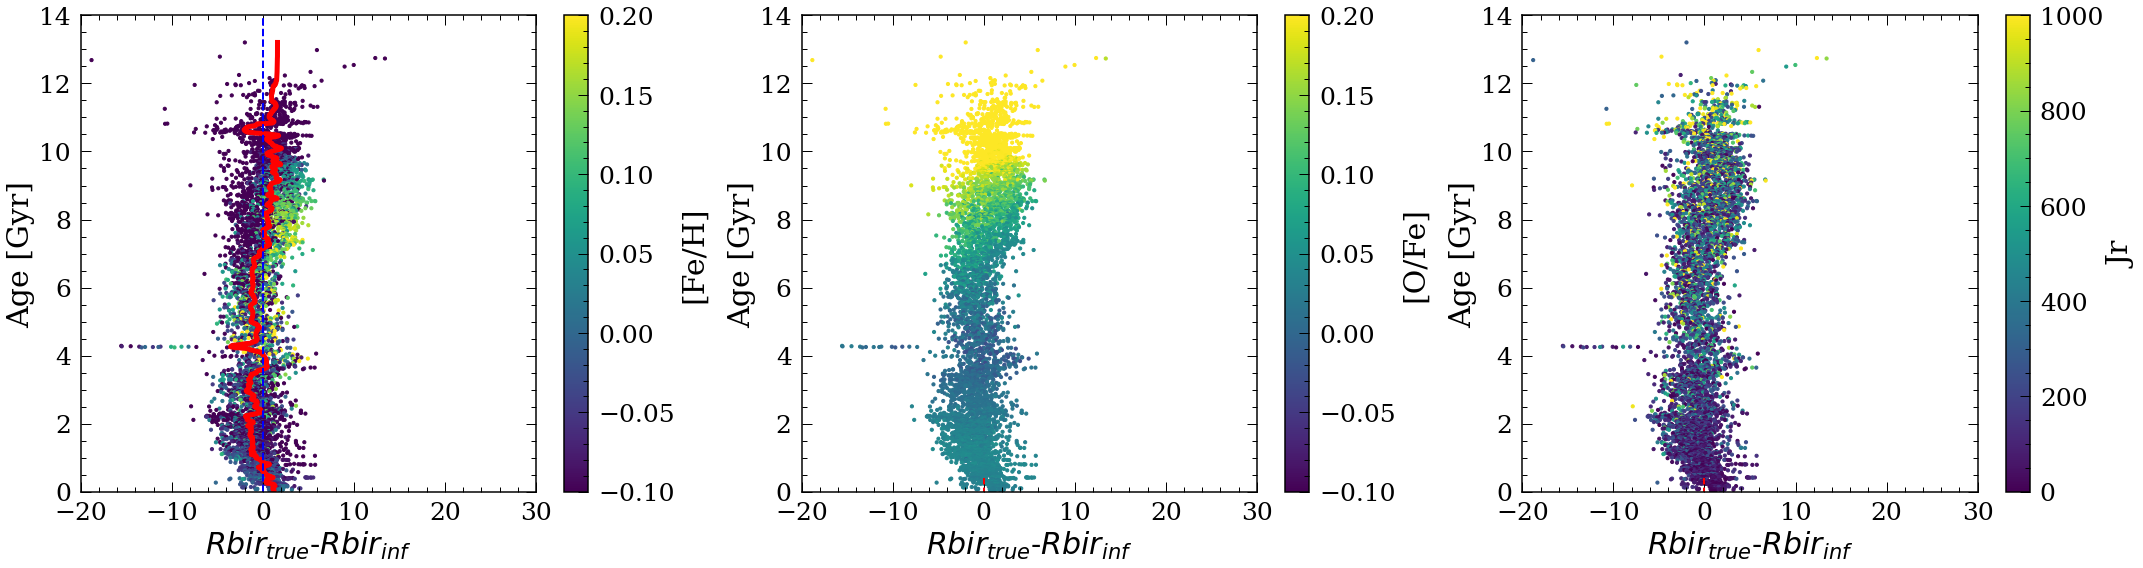

In [79]:
from scipy.ndimage import gaussian_filter1d
p_hilow=fitpoints([-0.8,0.6],[0.25,-0.06])
data_sr=data[m_sr]
data_sr['hi_low']=data_sr['ofe_scale']-p_hilow(data_sr['feh_scale'])>0
m_ha=(data_sr['hi_low']==1)
data_ha=data_sr.loc[m_ha]
m_la=(data_sr['hi_low']==0)
data_la=data_sr.loc[m_la]

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.scatter(r_birth_true-rbirth_inf, data_sr['age'].values, s=10, 
            c = data_sr['feh_scale'].values, vmin=-0.1,vmax=0.2)

age_smooth, dr = zip(*sorted(zip(data_sr['age'].values, r_birth_true-rbirth_inf)))
dr_smooth = gaussian_filter1d(dr, 20)
plt.plot(dr_smooth,age_smooth,'r-',linewidth=5)

plt.plot([0,0],[0,14],'b--')
plt.ylim([0,14])
plt.xlim([-20,30])
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.ylabel('Age [Gyr]')
cbar = plt.colorbar()
cbar.set_label('[Fe/H]',labelpad = 5)

plt.subplot(1,3,2)
plt.scatter(r_birth_true-rbirth_inf, data_sr['age'].values, s=10, 
            c = data_sr['ofe_scale'].values, vmin=-0.1,vmax=0.2)
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.plot([0,0],[-0.1,0.4],'r--')
plt.ylim([0,14])
plt.xlim([-20,30])
plt.ylabel('Age [Gyr]')
cbar = plt.colorbar()
cbar.set_label('[O/Fe]',labelpad = 5)

plt.subplot(1,3,3)
plt.scatter(r_birth_true-rbirth_inf, data_sr['age'].values, s=10, 
            c = data_sr['Jr'].values,vmin=0,vmax=1000)
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.plot([0,0],[-0.1,0.4],'r--')
plt.ylim([0,14])
plt.xlim([-20,30])
plt.ylabel('Age [Gyr]')
cbar = plt.colorbar()
cbar.set_label('Jr',labelpad = 5)
plt.tight_layout()